<a href="https://colab.research.google.com/github/roman-ruzica/hackprague2020_ganchors/blob/main/hackaton2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import statsmodels.api as sm
import calendar
from joblib import dump, load
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.3.0


In [3]:
data = pd.read_csv("/content/drive/My Drive/CS_HACKATHON/hackprague_txs(1).csv", sep = ";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (8,12,13) have mixed types.Specify dtype option on import or set low_memory=False.



In [7]:
## create yearmonth column just in case
data['year'] = pd.DatetimeIndex(data['tx_date']).year
data['month'] = pd.DatetimeIndex(data['tx_date']).month
data['day'] = 1
data["yearmonth"] = pd.to_datetime(data[["year", "month", "day"]])

In [9]:
## only take the full months which are not in the future

data2 = data[data['yearmonth'] > datetime.datetime(2020,4,15)]
data2 = data2[data['yearmonth'] < datetime.datetime(2020,10,20)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [22]:
data_small = data[["client_id", "region"]].groupby(["client_id"]).agg(pd.Series.mode)


In [36]:
data_small2 = data_small.reset_index().rename({"region":"client_region"}, axis =1)

In [42]:
data_small = data_small.reset_index()

In [47]:
pop_table = pd.read_csv("/content/drive/My Drive/CS_HACKATHON/pop_table - Sheet1.csv", sep = ",")

In [65]:
pop_table["region"] = pop_table["region"].astype("category")

In [75]:
data_small["region"] = pd.Series(data_small["region"])

In [77]:
data_small.dtypes

client_id     int64
region       object
dtype: object

In [ ]:
data_small[:,["region"]]

In [82]:
data_small.to_csv("data_small_mapping.csv", index = False)

In [86]:
data_small_read = pd.read_csv("data_small_mapping.csv")

In [87]:
data_small_read

,client_id,region
0,27,Olomouc
1,28,Ostrava-město
2,30,Beroun
3,33,Hlavní město Praha
4,46,Hlavní město Praha
...,...,...
49995,200964,Hradec Králové
49996,200977,Kladno
49997,200993,Plzeň-sever
49998,200995,Hlavní město Praha


In [64]:
len(data_small.columns)
data_small.dtypes

client_id     int64
region       object
dtype: object

In [102]:
data_small_read.client_id.value_counts().sort_values()

133204    1
123968    1
100335    1
75771     1
77818     1
         ..
81928     1
108665    1
12294     1
4194      1
65536     1
Name: client_id, Length: 50000, dtype: int64

In [89]:
town_mapping = data_small_read\
.merge(pop_table,how = 'inner', on = ["region"])

In [95]:
key_diff = set(town_mapping.region).difference(data_small_read.region)
where_diff = town_mapping.region.isin(key_diff)

In [ ]:
town_mapping = data_small_read


In [107]:

outer_join = data_small_read[["region"]].merge(pop_table[["region"]], how = 'outer',indicator = True)

anti_join = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)

In [111]:
anti_join.to_csv("fidgety_customers.csv", index = False)

In [92]:
len(data_small_read.index)

50000

In [91]:
len(town_mapping.index)

49911

In [121]:
anti_join_list = anti_join.iloc[:,].tolist()

IndexError: ignored

In [ ]:
anti_join_list

In [116]:
data2.dtypes

transaction_id                   int64
tx_date                         object
client_id                        int64
client_gender                   object
client_year_of_birth           float64
amount                           int64
merchant_uid                    object
merchant_category               object
shop_tags                       object
merchant_category_id           float64
shop_uid                        object
shop_type                       object
region                          object
country                         object
year                             int64
month                            int64
day                              int64
yearmonth               datetime64[ns]
client_age                     float64
dtype: object

In [122]:
data3 = pd.merge(data2, town_mapping, how = "inner", on = "client_id")

In [11]:
data2["client_age"] = 2020 - data2["client_year_of_birth"]

In [125]:
data3 = data3.rename({"region_y":"client_home_region"}, axis =  1)

In [126]:
data3.to_csv("enriched_data.csv")

In [3]:
data3 = pd.read_csv("/content/drive/My Drive/CS_HACKATHON/enriched_data.csv")

In [ ]:
client_table = data3.groupby(["client_id", "population", "client_home_region", "client_gender", "merchant_category", "client_year_of_birth"]).agg({"amount":"sum"}).reset_index()

client_table2 = client_table.groupby(["client_id", "client_gender", "population", "client_home_region", "client_year_of_birth"]).agg({"amount":"sum"})\
.rename({"amount":"tot_m_amount"}).reset_index()
client_table_tot = client_table.merge(client_table2,on = ["client_id", "population", "client_home_region", "client_gender", "client_year_of_birth"])

In [4]:
client_table = data3.groupby(["client_id", "population", "client_home_region", "client_gender", "merchant_category", "client_year_of_birth"]).agg({"amount":"sum"}).reset_index()

client_table2 = client_table.groupby(["client_id", "client_gender", "population", "client_home_region", "client_year_of_birth"]).agg({"amount":"sum"})\
.rename({"amount":"tot_m_amount"}).reset_index()
client_table_tot = client_table.merge(client_table2,on = ["client_id", "population", "client_home_region", "client_gender", "client_year_of_birth"])

In [5]:
client_table_tot["client_home_region"] = client_table_tot["client_home_region"].astype('category')
client_table_tot["client_home_region_cat"] = client_table_tot["client_home_region"].cat.codes
client_table_tot.head()


,client_id,population,client_home_region,client_gender,merchant_category,client_year_of_birth,amount_x,amount_y,client_home_region_cat
0,27,235472,Olomouc,Male,Atm,1985.0,-44607,-229973,38
1,27,235472,Olomouc,Male,Beauty,1985.0,-1030,-229973,38
2,27,235472,Olomouc,Male,Car,1985.0,-2893,-229973,38
3,27,235472,Olomouc,Male,Children,1985.0,-2233,-229973,38
4,27,235472,Olomouc,Male,Consumer Goods,1985.0,-44,-229973,38


In [6]:
client_table_tot[["gen_dummy", "gd2"]] = pd.get_dummies(client_table_tot["client_gender"])

In [138]:
client_table_tot.to_csv("/content/drive/My Drive/CS_HACKATHON/model_data.csv")

In [7]:
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    print(model.rsquared, model.mse_resid)

0.643036860130832 7088367152.553399
0.19505517234253333 37908215.82096588
0.29073779391256427 468945718.63939714
0.25252508510454685 9056860.89851216
0.1920288105743453 55970279.58028257
0.11111012896718553 829259331.3680534
0.4857122338637684 9796726.02514981
0.18903614499704835 234521874.997703
0.49847629431587936 83029309.8458023
0.3822092236950658 7958680344.094479
0.6798107466944102 604576845.4969293
0.307432018635417 14304617.872161342
0.13384914999103525 446274556.8976223
0.2699661124001841 290760695.67298913
0.2591400733134549 111088564.78736064
0.2877530226577555 381344678.753501
0.28621186907353235 10382417.613060953
0.2480726502016254 292887383.3097777
0.24931931846884092 74647933.61487778
0.2049885707951189 21459014.144421328
0.25920306503500623 5022031.785937097
0.22474471002280882 3067164927.644088


In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline



In [9]:
model_type = "Polynomial_regression"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(X, y)
    predictions = model.predict(X) # make the predictions by the model
    dump(model,
         f'/content/drive/My Drive/CS_HACKATHON/models/{model_type}_{cat}.joblib') 
    # Print out the statistics
    print(sklearn.metrics.mean_absolute_error(y, predictions))


Polynomial_regression
29424.178930840484
2430.964714160231
8907.01308294266
1522.1488249209815
2893.736101089636
6770.102730353388
2041.4725664186901
6477.164325923018
5372.295891070098
20803.245207454533
15298.44853093642
1962.5624611946096
7112.152006451269
7634.293652076497
5374.38465717431
9151.917398562302
1841.073455580981
6651.942585594879
3984.3641970043195
2571.353962408936
1075.7929649889663
20098.182467881135


In [ ]:
list(client_table_tot.merchant_category.unique())

In [ ]:
model_type = "Polynomial_regression"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(X, y)
    predictions = model.predict(X) # make the predictions by the model
    dump(model,
         f'/content/drive/My Drive/CS_HACKATHON/models/{model_type}_{cat}.joblib') 
    # Print out the statistics
    print(sklearn.metrics.mean_absolute_error(y, predictions))


In [11]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [12]:
model_type = "xgboost_squarederror"
print(model_type)
for cat in list(client_table_tot.merchant_category.unique()):
    client_table_specific = client_table_tot[client_table_tot["merchant_category"] == cat]
    X = client_table_specific[["client_id", "client_home_region_cat", "population", "gen_dummy", "client_year_of_birth", "amount_y"]]
    y = client_table_specific["amount_x"]
    
    # Note the difference in argument order
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model = model.fit(X, y)
    predictions = model.predict(X) # make the predictions by the model
    dump(model,
         f'/content/drive/My Drive/CS_HACKATHON/models/{model_type}_{cat}.joblib') 
    # Print out the statistics
    print(cat, sklearn.metrics.mean_absolute_error(y, predictions))


xgboost_squarederror
Atm 26419.581445364714
Beauty 2360.355930314245
Car 8252.313238775756
Children 1460.2601022123613
Consumer Goods 2794.9348523833223
Digital Services 5292.024180780575
Drugstore 1919.6977813355434
Electronics 6226.692438763851
Food And Drink 5195.08267599434
Freetime 14915.40008716379
Groceries 13712.494758004252
Health 1892.8530598637801
Professional Services 4643.825629452862
Shopping Online 7435.687366900704
Travel 5281.20816715055
House And Garden 8846.426168281178
Pets 1793.4864099101494
Fashion 6422.292253235305
Sport 3703.4400978059143
Bills And Household 2304.631094447246
Culture 1056.0432325739562
Financial Services 16805.568190924005


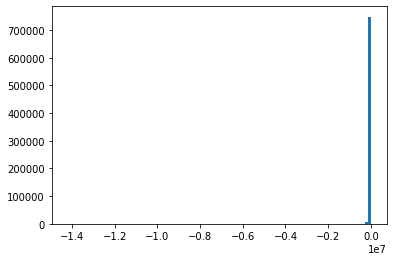

In [17]:
import matplotlib.pyplot as plt

plt.hist(client_table_tot["amount_x"], bins = 100)
plt.show()

In [170]:
client_table_tot["amount_x"].sort_values()

348684   -14232728
736950    -8839500
524387    -8297540
229421    -7833650
749947    -7622974
            ...   
19045         6958
35553         7926
111943       15838
33449        23528
94411        26531
Name: amount_x, Length: 755067, dtype: int64

In [174]:
client_table_tot.loc[:, ["client_id", "amount_x"]].sort_values("amount_x")

,client_id,amount_x
348684,77975,-14232728
736950,192571,-8839500
524387,122244,-8297540
229421,51624,-7833650
749947,198871,-7622974
...,...,...
19045,3902,6958
35553,7320,7926
111943,24561,15838
33449,6855,23528


In [20]:
data3[data3["client_id"] == 20506].sort_values("amount")

,Unnamed: 0,transaction_id,tx_date,client_id,client_gender,client_year_of_birth,amount,merchant_uid,merchant_category,shop_tags,merchant_category_id,shop_uid,shop_type,region_x,country,year,month,day,yearmonth,client_age,client_home_region,population
12398305,12398305,10073145,2020-10-22,20506,Male,1995.0,-5100,ReW7Dekd9jUbXvZYVzmGzR,Atm,{Atm-All},9.999900e+04,dVSgKooPh5sJdAHgt4Imzp,ATM,Frýdek-Místek,CZ,2020,10,1,2020-10-01,25.0,Ostrava-město,320145
12398073,12398073,3697553,2020-10-02,20506,Male,1995.0,-2624,D7AM0AYJW3SXG0kNLlj79Y,Groceries,"{Hyper-Supermarket,Online Groceries,Shopping O...",1.510000e+02,REjZgp098rtYjmz32nBJQN,ONLINE,NaN,NaN,2020,10,1,2020-10-01,25.0,Ostrava-město,320145
12398069,12398069,2914109,2020-09-07,20506,Male,1995.0,-2212,Ve2LvJzWadip25o9YaWdmy,Shopping Online,"{Eshop With Everything,Shopping Online}",1.483997e+06,ek4lgzQNMvTMy2J8YmKKkd,ONLINE,NaN,CZ,2020,9,1,2020-09-01,25.0,Ostrava-město,320145
12398306,12398306,10073567,2020-09-18,20506,Male,1995.0,-1560,ReW7Dekd9jUbXvZYVzmGzR,Atm,{Atm-All},9.999900e+04,dVSgKooPh5sJdAHgt4Imzp,ATM,Frýdek-Místek,CZ,2020,9,1,2020-09-01,25.0,Ostrava-město,320145
12398115,12398115,6974733,2020-09-15,20506,Male,1995.0,-1442,lodeWpPR8Bh99MyKmzBbBk,Car,{Gas Station},1.390000e+02,7LVmMzqkn5IvzA3dab3LJn,MERCHANT,Benešov,CZ,2020,9,1,2020-09-01,25.0,Ostrava-město,320145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12398072,12398072,3687006,2020-10-20,20506,Male,1995.0,-11,85R0XQVgN5h995Q19K30,Travel,"{Air Tickets,Bus,Long Distance Transport,Onlin...",1.400000e+02,ZKLAAm3qzpTN7Bq9pgL3V9,ONLINE,NaN,NaN,2020,10,1,2020-10-01,25.0,Ostrava-město,320145
12398247,12398247,9153543,2020-10-08,20506,Male,1995.0,-8,0zDr11JlGmIKlM173lyrrE,Travel,"{Long Distance Transport,Online Travel,Shoppin...",1.400000e+02,ay4B3zomepcAdQRoAv3839,ONLINE,NaN,CZ,2020,10,1,2020-10-01,25.0,Ostrava-město,320145
12398251,12398251,9192766,2020-05-31,20506,Male,1995.0,-5,0zDr11JlGmIKlM173lyrrE,Travel,"{Long Distance Transport,Online Travel,Shoppin...",1.400000e+02,ay4B3zomepcAdQRoAv3839,ONLINE,NaN,CZ,2020,5,1,2020-05-01,25.0,Ostrava-město,320145
12398266,12398266,9278241,2020-05-10,20506,Male,1995.0,-5,0zDr11JlGmIKlM173lyrrE,Travel,"{Long Distance Transport,Online Travel,Shoppin...",1.400000e+02,ay4B3zomepcAdQRoAv3839,ONLINE,NaN,CZ,2020,5,1,2020-05-01,25.0,Ostrava-město,320145


In [21]:
data3[data3["amount"] >= 0].sort_values("amount")

,Unnamed: 0,transaction_id,tx_date,client_id,client_gender,client_year_of_birth,amount,merchant_uid,merchant_category,shop_tags,merchant_category_id,shop_uid,shop_type,region_x,country,year,month,day,yearmonth,client_age,client_home_region,population
5769366,5769366,10585007,2020-08-17,119739,Male,1995.0,0,drrYz8DXpNsVmdN9zkpJ11,NaN,{Shopping Online},NaN,MjZQZqNd2Frp29BM4zVW,ONLINE,NaN,NaN,2020,8,1,2020-08-01,25.0,Hlavní město Praha,1324277
12685152,12685152,10584952,2020-09-25,167669,Male,1995.0,0,drrYz8DXpNsVmdN9zkpJ11,NaN,{Shopping Online},NaN,MjZQZqNd2Frp29BM4zVW,ONLINE,NaN,NaN,2020,9,1,2020-09-01,25.0,Hlavní město Praha,1324277
5690677,5690677,13060886,2020-09-28,57006,Male,1995.0,0,5qL1AD9PXhdVdnGP88rDY,Shopping Online,NaN,1483997.0,8vOg93Rz7oxs2GzQERcNYl,ONLINE,NaN,CN,2020,9,1,2020-09-01,25.0,Hlavní město Praha,1324277
5788783,5788783,2097339,2020-06-13,78842,Female,1990.0,0,EWQp90vaJvsgB473KLQ1qj,Food And Drink,{Restaurant Without A Waiter},147.0,Ey2Rp93oQ9iGr4Lm8ZGYlG,MERCHANT,Hlavní město Praha,CZ,2020,6,1,2020-06-01,30.0,Hlavní město Praha,1324277
10099054,10099054,13073142,2020-06-17,26210,Male,1990.0,0,5qL1AD9PXhdVdnGP88rDY,Shopping Online,NaN,1483997.0,8vOg93Rz7oxs2GzQERcNYl,ONLINE,NaN,CN,2020,6,1,2020-06-01,30.0,Frýdek-Místek,214660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13092332,13092332,2586771,2020-05-05,22991,Male,1980.0,27245,Ve2LvJzWadip25o9YaWdmy,Shopping Online,"{Eshop With Everything,Shopping Online}",1483997.0,ek4lgzQNMvTMy2J8YmKKkd,ONLINE,NaN,CZ,2020,5,1,2020-05-01,40.0,Ústí nad Orlicí,138275
1036033,1036033,8064841,2020-05-12,23583,Male,1990.0,30707,RQBXzp9yp9SWAZBel9m7Bp,Financial Services,"{Online Financial Services,Shopping Online,Sto...",152.0,n9LZoGmYWDIMMBpa23JPMe,ONLINE,NaN,CY,2020,5,1,2020-05-01,30.0,Plzeň-město,194280
6557258,6557258,2597178,2020-05-03,6855,Male,1985.0,33319,Ve2LvJzWadip25o9YaWdmy,Shopping Online,"{Eshop With Everything,Shopping Online}",1483997.0,ek4lgzQNMvTMy2J8YmKKkd,ONLINE,NaN,CZ,2020,5,1,2020-05-01,35.0,Hlavní město Praha,1324277
1212103,1212103,10661270,2020-05-15,19441,Male,1985.0,35451,P9D5m7VaZvt7ArlK4q8Y7l,Travel,"{Air Tickets,Long Distance Transport,Online Tr...",140.0,vp1aJkD4yPSGb2oLGkmZ79,ONLINE,NaN,NaN,2020,5,1,2020-05-01,35.0,Hlavní město Praha,1324277
